# PINN for coupled DE

A single neural network implementation (as opposed to two neural networks) of [PINN_coupledDe.ipynb](PINN_coupledDe.ipynb))

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation


In [2]:
class NN(tf.keras.Model):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            activation: str = 'tanh'
    )->None:
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons

        NNLayers = []
        for _ in range(num_hidden_layers):
            NNLayers.append(tf.keras.layers.Dense(units=num_neurons, activation=activation)) # the hidden layers
        NNLayers.append(tf.keras.layers.Dense(units=2)) # the output layer

        self.NNLayers = NNLayers

    def call(
            self,
            input: tf.Tensor
    )->tf.Tensor: # the neural network call implements the forward call, where it runs the input through the first layer, and then feeds the output of the first layer to the second layer and so on
        output = tf.reshape(input, shape=(-1, self.num_inputs))
        for layer in self.NNLayers:
            output = layer(output)
        return output


In [3]:
NUM_LAYERS = 7
NUM_NEURONS = 7
EPOCHS = 10000 #how many times the training step is performed
BATCH_SIZE = 50 # how many input values are considered for each epoch
LEARNING_RATE = 5e-3 #learning rate
TOLERANCE = 1e-4 # error tolerance
NUM_INPUTS = 1

T_DOMAIN = (0.0, 20.0)
X1_DOMAIN = (-2.0, 2.0)
X2_DOMAIN = (-2.0, 2.0)

def loss_fun(
        model: tf.keras.Model, 
        t: tf.Tensor,
        x1_0: float, # Init value of x1, i.e. x1(0)
        x2_0: float, # Init value of x2, i.e. x2(0)
)-> tf.Tensor:

    with tf.GradientTape(persistent=True) as tape: 
        tape.watch(t)
        x1_val = tf.gather(tf.reshape(model(t), shape=(-1,2)), [0], axis=1)
        x2_val = tf.gather(tf.reshape(model(t), shape=(-1,2)), [1], axis=1)

    dx1_dt = tape.gradient(x1_val, t)
    dx2_dt = tape.gradient(x2_val, t)

    del tape

    de1 = dx1_dt + (1/2)*x1_val - x2_val
    de2 = dx2_dt + x1_val + (1/2)*x2_val

    b = model(tf.convert_to_tensor([0.0, 0.0])) - tf.convert_to_tensor([x1_0, x2_0])

    loss_val = tf.reduce_mean(tf.square(de1) + tf.square(de2)) + tf.reduce_mean(tf.square([b]))

    return loss_val 

In [4]:
from IPython.display import clear_output

def train( # train the model for a given initial conditions and returns the predictions of the model
        x_0: tuple[float]
    ) -> tuple[tf.Tensor, tf.Tensor]:

    clear_output(wait=True)

    (x1_0, x2_0) = x_0 # initial boundary conditions
    print(x_0)
    model = NN(num_inputs=NUM_INPUTS, num_hidden_layers= NUM_LAYERS, num_neurons=NUM_NEURONS)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    @tf.function
    def train_step(model, input, x1_0, x2_0): # function for one single training step
        with tf.GradientTape(persistent=True) as tape:
            loss = loss_fun(model, input, x1_0, x2_0)

        gradients = tape.gradient(loss, model.trainable_variables) # calculate the gradients of the loss with respect to \theta
        optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # optimize the parameters to minimize the loss

        del tape
        return loss
    
    for epoch in range(EPOCHS):
        input_batch = tf.keras.random.uniform(shape=(BATCH_SIZE, NUM_INPUTS), minval=T_DOMAIN[0], maxval=T_DOMAIN[1], dtype=tf.float32) #randomly sample BATCH_SIZE number of points from the domain
        loss = train_step(model, input_batch, x1_0, x2_0) # run the train step for the given batch
        if epoch % 10 == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')
        if loss <= TOLERANCE:
            print(f'Converged at epoch {epoch}')
            break

    t = tf.linspace(T_DOMAIN[0], T_DOMAIN[1], 500)[:, tf.newaxis]

    pred = tf.reshape(model(t), shape=(-1,2))
    
    x1_pred = tf.gather(pred, [0], axis=1)
    x2_pred = tf.gather(pred, [1], axis=1)

    return (x1_pred, x2_pred)

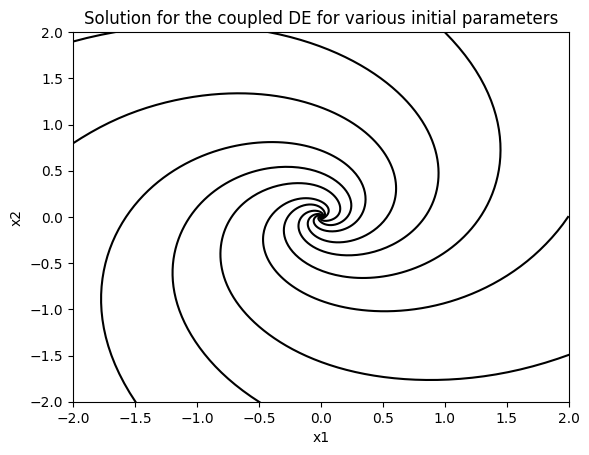

In [5]:
inits = [(2.0, 0.0), (2.0, -1.5), (-0.5, -2.0), (-1.5, -2.0), (-2.0, 0.8), (-2.0, 1.9), (1.0, 2.0)]
losses = []

for init in inits:
    x1_pred, x2_pred = train(init)
    plt.plot(x1_pred, x2_pred, color='black')


clear_output()

plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Solution for the coupled DE for various initial parameters")
plt.show()